In [1]:
!ls

Basics.ipynb  chinook.db  chinook.db.bak  chinook-unmodified.db


In [2]:
!cp chinook.db chinook.db.bak
!ls

Basics.ipynb  chinook.db  chinook.db.bak  chinook-unmodified.db


In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

In [4]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(q):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(q)
        
def show_tables():
    query = '''
    SELECT name, type FROM sqlite_master WHERE type IN ("table", "view");
    '''
    return run_query(query)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
query = '''
WITH total_sold_usa AS
(SELECT SUM(quantity) FROM invoice_line il
JOIN invoice i ON i.invoice_id = il.invoice_id
JOIN customer c ON c.customer_id = i.customer_id
WHERE c.country = "USA")

SELECT g.name, SUM(quantity) tracks_sold,
ROUND(CAST(SUM(quantity) as float) / (SELECT * FROM total_sold_usa) * 100, 2) tracks_sold_pct
FROM genre g
JOIN track t ON g.genre_id = t.genre_id
JOIN invoice_line il ON il.track_id = t.track_id
JOIN invoice i ON i.invoice_id = il.invoice_id
JOIN customer c ON c.customer_id = i.customer_id
WHERE c.country = "USA"
GROUP BY 1;
'''
sold_by_genre = run_query(query)
sold_by_genre.set_index("name", drop=True, inplace=True)
sold_by_genre

,tracks_sold,tracks_sold_pct
name,,
Alternative,35,3.33
Alternative & Punk,130,12.37
Blues,36,3.43
Classical,4,0.38
Easy Listening,13,1.24
Electronica/Dance,5,0.48
Heavy Metal,3,0.29
Hip Hop/Rap,20,1.90
Jazz,14,1.33


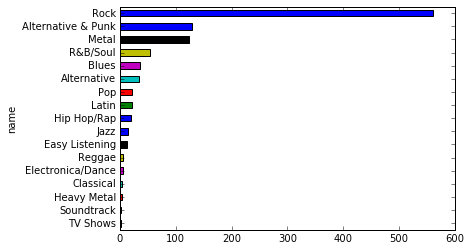

In [14]:
sold_by_genre["tracks_sold"].sort_values().plot.barh()

In [8]:
sold_by_genre.sort_values(by=["tracks_sold"], ascending=False)

,tracks_sold,tracks_sold_pct
name,,
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.80
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Latin,22,2.09
Pop,22,2.09
Hip Hop/Rap,20,1.90


Adding the album of the **Punk band (Red Tone)** is heavily recommended as that addresses over 12% of the sales in the US.

The next recommendation would be the **Blues band (Slim Jim Bites)** as it is covered by almost 3.5% of the US sales.

Finally, the **Hip-Hop band (Regal)** should be also added to the collection. While Hip-Hop albums are only sold 1.9% of the time, but it is fairly close to the R&B/Soul (5% of sales) which heavily outweighs the slight advantage of the Pop genre (2.1% of sales).

In [9]:
query = '''
SELECT (e.first_name || " " || e.last_name) employee_name,
e.birthdate, e.hire_date, -- dates
e.city, e.state, e.country, -- location
e.reports_to, -- hierarchy
SUM(i.total) total_sales
FROM employee e
JOIN customer c ON e.employee_id = c.support_rep_id
JOIN invoice i ON c.customer_id = i.customer_id
WHERE e.title = "Sales Support Agent"
GROUP BY 1
'''

sales_by_employee = run_query(query)
sales_by_employee.set_index("employee_name", drop=True, inplace=True)

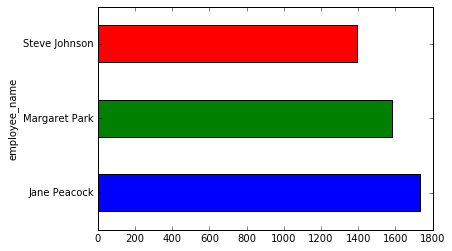

In [10]:
sales_by_employee["total_sales"].plot.barh()

In [11]:
sales_by_employee

,birthdate,hire_date,city,state,country,reports_to,total_sales
employee_name,,,,,,,
Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,Calgary,AB,Canada,2,1731.51
Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,Calgary,AB,Canada,2,1584.00
Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,Calgary,AB,Canada,2,1393.92


**Jane Peacock** has the highest sales, however she has been also with the company for the longest time - since April 2017.
**Margaret Park** has sold approximately 150 dollars less with one less month of employment.
Finally, **Steve Johnson** is another 200 dolars short of her while being employed only since mid-October 2017.
Overall, their numbers are quite close, with Jane having the highest average monthly sales while Steve is the second best sales employee.

In [12]:
# backup

query = '''
WITH other_country_totals AS
(SELECT c.country, i.total
FROM customer c
JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
HAVING COUNT(DISTINCT c.customer_id) = 1)

SELECT
    CASE
        WHEN c.country IN (SELECT country FROM other_country_totals) THEN "Other"
        ELSE c.country
    END AS country,
    COUNT(country)
FROM customer c
GROUP BY 1
        
'''

run_query(query)

,country,COUNT(country)
0,Brazil,5
1,Canada,8
2,Czech Republic,2
3,France,5
4,Germany,4
5,India,2
6,Other,15
7,Portugal,2
8,USA,13
9,United Kingdom,3


In [19]:
query = '''
WITH other_countries AS
(SELECT c.country
FROM customer c
JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
HAVING COUNT(DISTINCT c.customer_id) = 1),

customer_country_as_other AS
(SELECT
    c.customer_id,
    CASE
        WHEN c.country IN (SELECT oc.country FROM other_countries oc) THEN "Other"
        ELSE c.country
    END AS country,
    i.total AS sales
FROM customer c
JOIN invoice i ON i.customer_id = c.customer_id)

SELECT country,
COUNT(DISTINCT customer_id) AS nr_customers,
SUM(sales) AS total_sales,
ROUND(SUM(sales) / COUNT(DISTINCT customer_id),2) AS avg_sales_per_customer,
ROUND(AVG(sales), 2) AS avg_sales_per_order
FROM
(SELECT c.*,
CASE
    WHEN c.country = "Other" THEN 1
    ELSE 0
END AS sort
FROM customer_country_as_other c)
GROUP BY country
ORDER BY sort, 3 DESC;
'''

plot_df = run_query(query)
plot_df

,country,nr_customers,total_sales,avg_sales_per_customer,avg_sales_per_order
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Other,15,1094.94,73.00,7.45


In [22]:
plot_df = plot_df.set_index("country")

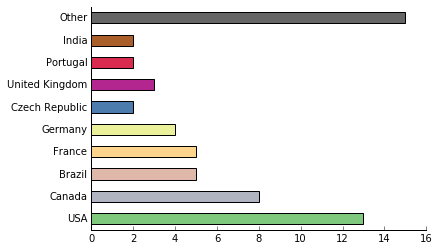

In [54]:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, plot_df.shape[0])]
fig, ax1 = plt.subplots()
plot_df["nr_customers"].plot.barh(ax=ax1, color=colors)
ax1.tick_params(top="off", right="off", left="off", bottom="on")
ax1.set_ylabel("")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

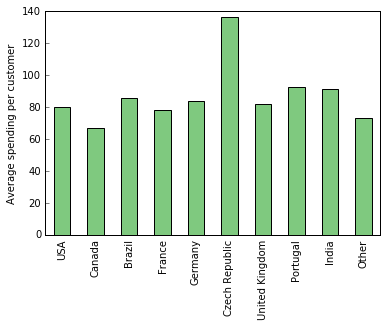

In [67]:
fig, ax2 = plt.subplots()
plot_df[["avg_sales_per_customer"]].plot.bar(ax=ax2, color=colors)
ax2.tick_params(top="off", right="off", left="on", bottom="off")
ax2.set_xlabel("")
ax2.set_ylabel("Average spending per customer")
ax2.legend().set_visible(False)

In [95]:
query = '''
WITH invoice_albums AS
(SELECT DISTINCT i.invoice_id, a.album_id FROM invoice i
JOIN invoice_line il ON il.invoice_id = i.invoice_id
JOIN track t ON t.track_id = il.track_id
JOIN album a ON a.album_id = t.album_id)

SELECT album_purchase,
    COUNT(DISTINCT invoice_id) number_of_invoices,
    ROUND(COUNT(DISTINCT invoice_id) / CAST((SELECT COUNT(DISTINCT invoice_id) FROM invoice_albums) AS float),3) percentage_of_invoices
FROM
    (SELECT ia.invoice_id invoice_id, ia.album_id album_id,
        CASE WHEN
            (SELECT track_id FROM track t
            WHERE t.album_id = ia.album_id

            EXCEPT

            SELECT track_id FROM invoice_line il
            WHERE il.invoice_id = ia.invoice_id) IS NULL
                AND
            (SELECT track_id FROM invoice_line il
            WHERE il.invoice_id = ia.invoice_id

            EXCEPT

            SELECT track_id FROM track t
            WHERE t.album_id = ia.album_id) IS NULL
        THEN "yes"
        ELSE "no"
        END AS "album_purchase"
    FROM invoice_albums ia)
    GROUP BY album_purchase;
'''

run_query(query)

,album_purchase,number_of_invoices,percentage_of_invoices
0,no,500,0.814
1,yes,114,0.186
